In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
pos = np.random.normal(0,1,300000)
neg = np.random.normal(0,0.5,100000)
posW = np.ones(len(pos))
negW = -np.ones(len(neg))
tot = np.concatenate([pos,neg])
totW = np.concatenate([posW,negW])

In [3]:
model = Sequential()
model.add(Dense(128, input_dim=1, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
x_vals = np.concatenate([tot,tot])
y_vals = np.concatenate([np.ones(len(tot)),np.zeros(len(tot))])
w_vals = np.concatenate([totW,np.ones(len(tot))])
X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(x_vals, y_vals, w_vals, test_size=0.5)

In [5]:
myhistory = model.fit(x_vals, y_vals, sample_weight=w_vals,epochs=10,validation_data=(X_val, Y_val, W_val),batch_size=int(0.1*len(X_train)),verbose=1,shuffle=True)


Train on 800000 samples, validate on 400000 samples
Epoch 1/10
800000/800000 [==============================] - 3s 4us/step - loss: 0.5012 - accuracy: 0.4999 - val_loss: 0.4825 - val_accuracy: 0.4999
Epoch 2/10
800000/800000 [==============================] - 2s 3us/step - loss: 0.4638 - accuracy: 0.5000 - val_loss: 0.4542 - val_accuracy: 0.5009
Epoch 3/10
800000/800000 [==============================] - 2s 3us/step - loss: 0.4539 - accuracy: 0.5002 - val_loss: 0.4538 - val_accuracy: 0.5003
Epoch 4/10
800000/800000 [==============================] - 2s 3us/step - loss: 0.4535 - accuracy: 0.5000 - val_loss: 0.4534 - val_accuracy: 0.5003
Epoch 5/10
800000/800000 [==============================] - 2s 3us/step - loss: 0.4533 - accuracy: 0.4999 - val_loss: 0.4532 - val_accuracy: 0.5003
Epoch 6/10
800000/800000 [==============================] - 2s 3us/step - loss: 0.4533 - accuracy: 0.5002 - val_loss: 0.4532 - val_accuracy: 0.5006
Epoch 7/10
800000/800000 [==============================] -

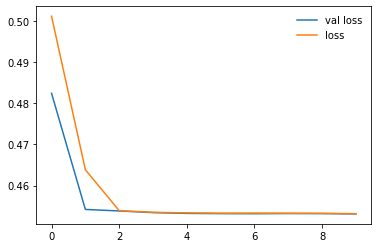

In [6]:
plt.plot(myhistory.history['val_loss'],label="val loss")
plt.plot(myhistory.history['loss'],label="loss")
plt.legend(frameon=False)

In [7]:
predicted_w = model.predict(X_val)

In [8]:
myw = predicted_w / (1.-predicted_w)

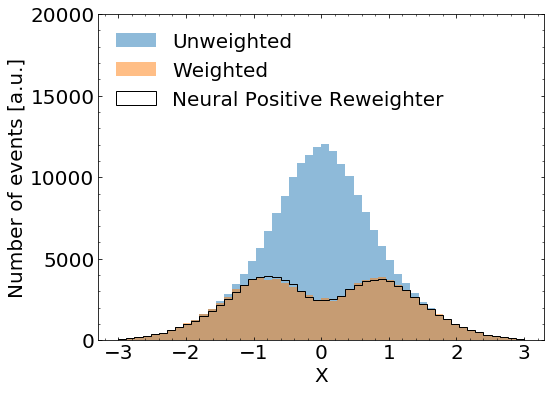

In [9]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(X_val[Y_val==0],bins=np.linspace(-3,3,51),alpha=0.5,label="Unweighted")
_,_,_=plt.hist(X_val[Y_val==1],weights=W_val[Y_val==1],bins=np.linspace(-3,3,51),alpha=0.5,label="Weighted")
_,_,_=plt.hist(X_val[Y_val==0],weights=myw[Y_val==0],bins=np.linspace(-3,3,51),label="Neural Positive Reweighter",histtype="step",color="black")
plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.ylim([0,20000])
plt.ylabel("Number of events [a.u.]",fontsize=20)
plt.xlabel("X",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.savefig("gauss.pdf",bbox_inches='tight')

In [10]:
from scipy.stats import norm
def analytic_weight(x):
    gaus1 = norm.pdf(x)*3
    gaus2 = norm.pdf(x,scale=0.5)
    #pos = np.random.normal(0,1,300000)
    #neg = np.random.normal(0,0.5,100000)
    return (gaus1-gaus2)/(gaus1+gaus2)

In [11]:
analytic_weights = analytic_weight(X_val)

## Now for reducing the stats.

In [12]:
keepprobs = myw[Y_val==1]**2
for i in range(len(keepprobs)):
    if (keepprobs[i] > 1.):
        keepprobs[i]=1.
        pass
    pass
keep = np.random.binomial(1,keepprobs)
initweights = myw[Y_val==1]
initxvals = X_val[Y_val==1]
neweights = []
newxvals = []
for i in range(len(keep)):
    if (keep[i]==1):
        neweights+=[1./(0.00001+initweights[i][0])]
        newxvals+=[initxvals[i]]
    pass

In [13]:
neweights = np.array(neweights)

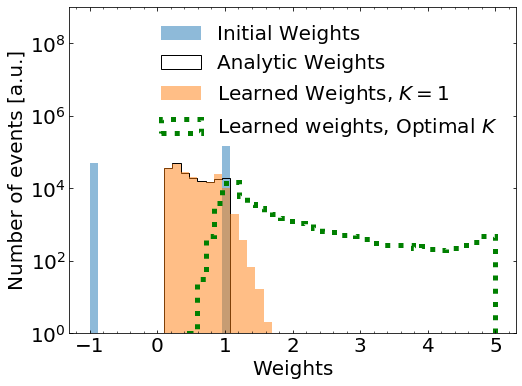

In [14]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(W_val[Y_val==1],label="Initial Weights",alpha=0.5,bins=np.linspace(-1,5,50))
plt.hist(analytic_weights[Y_val==0],label="Analytic Weights",color="black",histtype="step",bins=np.linspace(-1,5,50))
plt.hist(myw[Y_val==0],label="Learned Weights, $K=1$",alpha=0.5,bins=np.linspace(-1,5,50))
plt.hist(neweights,label=r"Learned weights, Optimal $K$",color="green",histtype="step",bins=np.linspace(-1,5,50),ls=":",linewidth=5)
plt.legend(frameon=False,fontsize=20)
plt.xlabel(r"Weights",fontsize=20)
plt.ylim([1,1e9])
plt.yscale("log")
plt.ylabel(r"Number of events [a.u.]",fontsize=20)
#plt.locator_params(axis='y', nbins=6)
plt.savefig("wgauss.pdf",bbox_inches='tight')

In [16]:
Bins_val = np.array([np.digitize(x,np.linspace(-3,3,51)) for x in X_val])

In [17]:
Bins_newval = np.array([np.digitize(x,np.linspace(-3,3,51)) for x in newxvals])

In [18]:
W2_original = [sum(W_val[(Y_val==1) & (Bins_val==i)]**2) for i in range(51)]
W2_new = [sum(myw[(Y_val==0) & (Bins_val==i)]**2) for i in range(51)]
W2_sampled = [sum(neweights[Bins_newval==i]**2) for i in range(51)]

L2_original = [len(W_val[(Y_val==1) & (Bins_val==i)]**2) for i in range(51)]
L2_new = [len(myw[(Y_val==0) & (Bins_val==i)]**2) for i in range(51)]
L2_sampled = [len(neweights[Bins_newval==i]**2) for i in range(51)]

In [27]:
W2_original = np.array(W2_original)
W2_new = np.array(W2_new)
W2_sampled = np.array(W2_sampled)

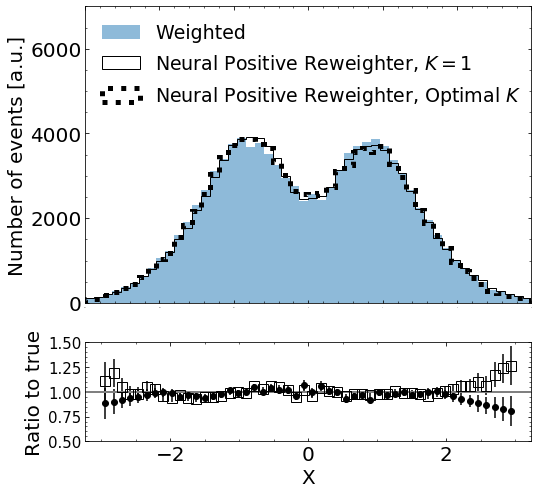

In [32]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#_,bins,_=plt.hist(X_val[Y_val==0],bins=np.linspace(-3,3,51),alpha=0.5,label="Unweighted")
myn2,bmjj,_=plt.hist(X_val[Y_val==1],weights=W_val[Y_val==1],bins=np.linspace(-3,3,51),alpha=0.5,label="Weighted")
myn3,_,_=plt.hist(X_val[Y_val==0],weights=myw[Y_val==0],bins=np.linspace(-3,3,51),label=r"Neural Positive Reweighter, $K=1$",histtype="step",color="black")
myn4,_,_=plt.hist(newxvals,weights=neweights,bins=np.linspace(-3,3,51),label=r"Neural Positive Reweighter, Optimal $K$",histtype="step",color="black",ls=":",linewidth=5)

plt.legend(frameon=False,fontsize=19,loc="upper left")
plt.xlim([-3,3])
plt.ylim([0,7000])
plt.ylabel("Number of events [a.u.]",fontsize=20)
plt.xlabel("",fontsize=20)
plt.xticks(fontsize=0)
plt.locator_params(axis='y', nbins=6)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.locator_params(axis='x', nbins=6)
plt.xlabel(r"X",fontsize=20)
plt.ylabel("Ratio to true",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1,linewidth=2, color='gray')   
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn3/myn2,yerr=(W2_new[:,0][:-1]+myn2)**0.5/myn2,color='black',fmt='s',fillstyle="none",markersize=10)
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn4/myn2,yerr=(W2_sampled[:-1]+myn2)**0.5/myn2,color='black',fmt="o")
plt.ylim(0.5,1.5)
#plt.xlim(-0.5,9.5)

plt.savefig("gauss_withK.pdf",bbox_inches='tight')

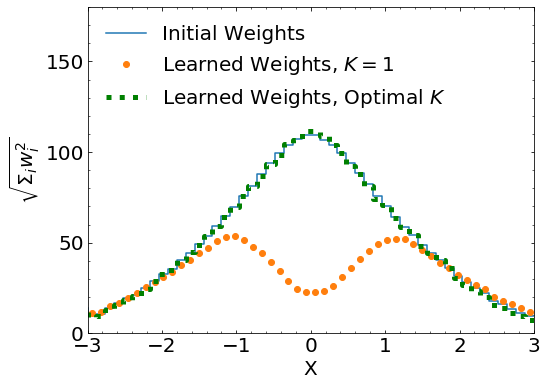

In [22]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.step(bins,np.array(W2_original)**0.5,label="Initial Weights")
plt.step(bins-0.5*6/51,np.array(W2_new)**0.5,label=r"Learned Weights, $K=1$",marker='o',ls="none")
plt.step(bins,np.array(W2_sampled)**0.5,label=r"Learned Weights, Optimal $K$",ls=":",linewidth=5,color="green")
plt.legend(frameon=False,fontsize=20,loc="upper left")

plt.ylim([0,180])
plt.xlim([-3,3])
plt.ylabel(r"$\sqrt{\Sigma_i w_i^2}$",fontsize=20)
plt.xlabel("X",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.savefig("gauss_sumw2.pdf",bbox_inches='tight')

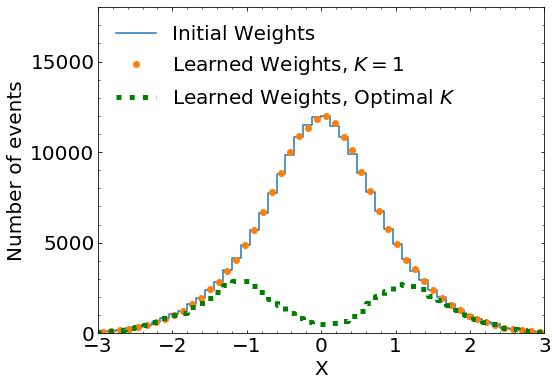

In [23]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.step(bins,L2_original,label="Initial Weights")
plt.step(bins-0.5*6/51,L2_new,label=r"Learned Weights, $K=1$",marker='o',ls="none")
plt.step(bins,L2_sampled,label=r"Learned Weights, Optimal $K$",ls=":",linewidth=5,color="green")
plt.legend(frameon=False,fontsize=20,loc="upper left")

plt.ylim([0,18000])
plt.ylabel("Number of events",fontsize=20)
plt.xlabel("X",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.xlim([-3,3])
plt.savefig("gauss_N.pdf",bbox_inches='tight')